# Plotting gridded DBPM outputs
**Author**: Denisse Fierro Arcos  
**Date**: 2025-02-06  

In this notebook, we will create a variety of plots using the outputs of gridded DBPM runs.

## Loading relevant libraries

In [1]:
import os
os.chdir('/g/data/vf71/la6889/lme_scale_calibration_ISMIP3a/new_workflow')
import useful_functions as uf
from glob import glob
import xarray as xr
import json
import numpy as np
import matplotlib.pyplot as plt
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
from dask.distributed import Client

## Start a cluster for parallelisation

In [2]:
client = Client(threads_per_worker = 1)

## Defining basic variables to run gridded DBPM

In [2]:
#Name of region and model resolution
region = 'fao-48'
model_res = '1deg'

#Defining input and output folders
base_folder = '/g/data/vf71/la6889/dbpm_inputs/weddell/'
gridded_outputs = os.path.join(base_folder, 'run_fishing', model_res)
plot_folder = os.path.join(base_folder, 'gridded_dbpm_outputs', model_res)
#If output folder does not exist, it will create it
os.makedirs(plot_folder, exist_ok = True) 

## Loading gridded parameters and biomass data

In [3]:
#Loading gridded parameters
gridded_params = json.load(open(
    os.path.join(base_folder, 'gridded_params', model_res,
                 f'dbpm_gridded_size_params_{region}_python.json')))

#Loading predators
predators = xr.open_mfdataset(glob(
    os.path.join(gridded_outputs, 'predators*')))['predators']

#Loading detritivores
detritivores = xr.open_mfdataset(glob(
    os.path.join(gridded_outputs, 'detritivores*')))['detritivores']

#Loading pelagic preferences
pel_pref = xr.open_zarr(glob(os.path.join(base_folder, 'gridded_params',
                                          model_res, 'pref-pelagic*'))[0])['pref_pelagic']

#Loading benthic preferences
ben_pref = xr.open_zarr(glob(os.path.join(base_folder, 'gridded_params',
                                          model_res, 'pref-benthos*'))[0])['pref_benthos']

#Size class bins
log10_size_bins_mat = xr.open_zarr('outputs/log10_size_bins_matrix.zarr/')['size_bins']
size_bin_vals = 10**log10_size_bins_mat

## Calculating mean preferences

In [4]:
pel_pref = np.round(pel_pref.mean().values.tolist(), 2)
ben_pref = np.round(ben_pref.mean().values.tolist(), 2)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/dask/_task_spec.py:740: RuntimeWarning: invalid value encountered in log10
  return self.func(*new_argspec)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/dask/_task_spec.py:740: RuntimeWarning: invalid value encountered in log10
  return self.func(*new_argspec)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/dask/_task_spec.py:740: RuntimeWarning: invalid value encountered in log10
  return self.func(*new_argspec)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/dask/_task_spec.py:740: RuntimeWarning: invalid value encountered in log10
  return self.func(*new_argspec)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/dask/_task_spec.py:740: RuntimeWarning: invalid value encountered in log10
  return self.func(*new_argspec)


## Subset biomass data 
Selecting relevant size classes for each group.

In [5]:
pred_summ = predators.isel(size_class = slice(gridded_params['ind_min_pred_size'], None)) 
det_summ = detritivores.isel(size_class = 
                             slice(gridded_params['ind_min_detritivore_size'], None)) 

## Preparing data before plotting 

### Option 1: Size spectrum from last available time step 

In [6]:
#Biomass is summed across area of interest
pred_summ_last = np.log10(pred_summ.isel(time = -1).sum(('lat', 'lon')))
det_summ_last = np.log10(det_summ.isel(time = -1).sum(('lat', 'lon')))

### Saving results 

In [8]:
size_spectra_last = xr.Dataset(data_vars = {'predators': pred_summ_last,
                                            'detritivores': det_summ_last})
#Getting last year from data
yr = str(size_spectra_last.time.dt.year.values.tolist())

#Saving plot
fn = f'size_spectrum_{region}_{model_res}_{yr}.nc'
size_spectra_last.to_netcdf(os.path.join(plot_folder, fn))

### Plotting size spectrum 

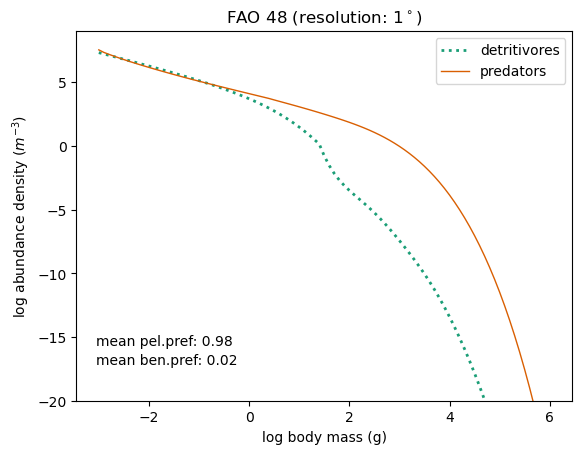

In [9]:
#Initialise figure
fig = plt.figure()
ax = fig.add_subplot()

#Plot detritivore and predator biomass
det_summ_last.plot(ax = ax, color = '#1b9e77', ls = 'dotted', lw = 2, 
              label = 'detritivores')
pred_summ_last.plot(ax = ax, color = '#d95f02', lw = 1, label = 'predators')

#Changing axes labels
ax.set_xlabel('log body mass (g)')
ax.set_ylabel('log abundance density ($m^{-3}$)')

#Adding legend
ax.legend(loc = 'upper right', frameon = True)

#Adding title
#Reformat region variable to use in title
reg_clean = region.upper().replace('-', ' ')
#Adding resolution to title
if model_res == '025deg':
    ax.set_title(f'{reg_clean} (resolution: 0.25$^\circ$)')
elif model_res == '1deg':
    ax.set_title(f'{reg_clean} (resolution: 1$^\circ$)')

#Setting minimum and maximum values along y axis
max_y = max([det_summ_last.max(), pred_summ_last.max()])
plt.ylim(-20, np.ceil(max_y.values)+1)

#Adding text
ax.text(0.04, 0.15, f'mean pel.pref: {pel_pref}', transform = ax.transAxes)
ax.text(0.04, 0.1, f'mean ben.pref: {ben_pref}', transform = ax.transAxes)

#Saving plot
fn = f'size_spectrum_{region}_{model_res}_{yr}.png'
plt.savefig(os.path.join(plot_folder, fn), dpi = 300, bbox_inches = 'tight', 
            pad_inches = 0.05)

### Option 2: Size spectrum from mean values across all timesteps 

In [10]:
pred_summ_all = np.log10(pred_summ.mean('time').sum(('lat', 'lon')))
det_summ_all = np.log10(det_summ.mean('time').sum(('lat', 'lon')))

### Saving results 

In [109]:
size_spectra_all = xr.Dataset(data_vars = {'predators': pred_summ_all,
                                           'detritivores': det_summ_all})
#Getting start and end years
s_yr = pred_summ.time.dt.year.min().values.tolist()
e_yr = pred_summ.time.dt.year.max().values.tolist()

#Saving plot
fn = f'size_spectrum_mean_{region}_{model_res}_{s_yr}-{e_yr}.nc'
size_spectra_all.to_netcdf(os.path.join(plot_folder, fn))

### Plotting size spectrum 

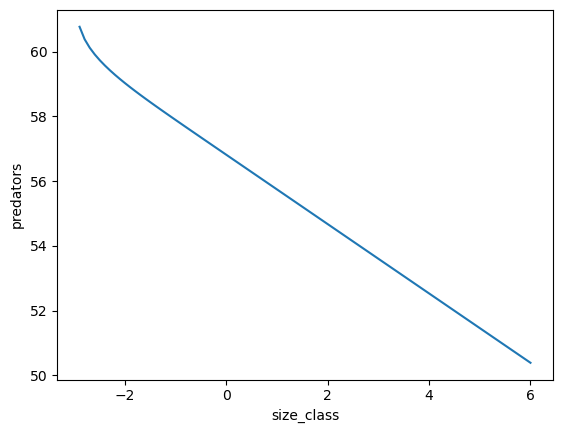

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/dask/_task_spec.py:740: RuntimeWarning: invalid value encountered in log10
  return self.func(*new_argspec)


In [11]:
pred_summ_all.plot()

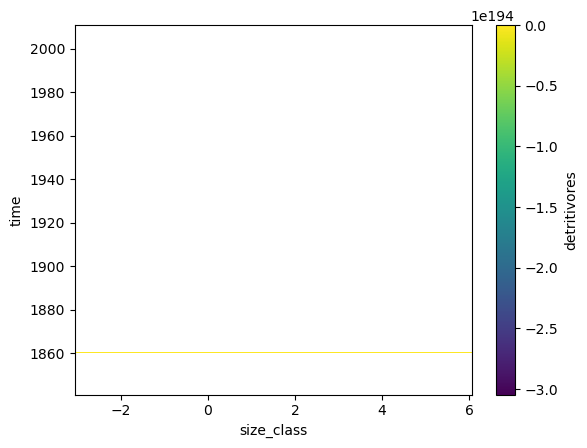

In [46]:
min_vals_det = det_summ.min(('lat', 'lon'))
min_vals_det.where(min_vals_det < 0).plot()

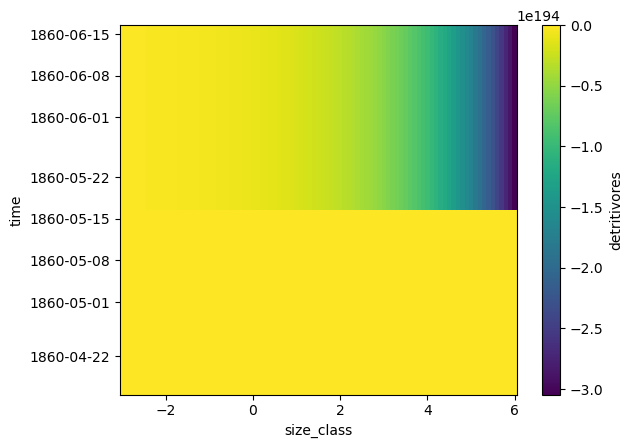

In [47]:
det_summ.sum(('lat', 'lon')).sel(time = slice('1860-05', '1860-06')).plot()

In [49]:
det_summ.sel(time = slice('1860-05', '1860-06')).sum(('lat', 'lon')).values

array([[-3.01376490e+094, -3.19234169e+094, -3.38149983e+094,
        -3.58186629e+094, -3.79410522e+094, -4.01892008e+094,
        -4.25705607e+094, -4.50930250e+094, -4.77649547e+094,
        -5.05952062e+094, -5.35931606e+094, -5.67687551e+094,
        -6.01325153e+094, -6.36955908e+094, -6.74697918e+094,
        -7.14676283e+094, -7.57023515e+094, -8.01879979e+094,
        -8.49394355e+094, -8.99724134e+094, -9.53036141e+094,
        -1.00950708e+095, -1.06932414e+095, -1.13268558e+095,
        -1.19980142e+095, -1.27089412e+095, -1.34619933e+095,
        -1.42596666e+095, -1.51046049e+095, -1.59996090e+095,
        -1.69476455e+095, -1.79518566e+095, -1.90155710e+095,
        -2.01423144e+095, -2.13358215e+095, -2.26000485e+095,
        -2.39391855e+095, -2.53576714e+095, -2.68602079e+095,
        -2.84517753e+095, -3.01376490e+095, -3.19234169e+095,
        -3.38149983e+095, -3.58186629e+095, -3.79410522e+095,
        -4.01892008e+095, -4.25705607e+095, -4.50930250e+095,
        

In [57]:
no_neg_det = xr.where(det_summ < 0, 0, det_summ)
det_summ_all = np.log10(no_neg_det.mean('time').sum(('lat', 'lon')))

# det_summ_all = np.log10(det_summ.mean('time').sum(('lat', 'lon')))

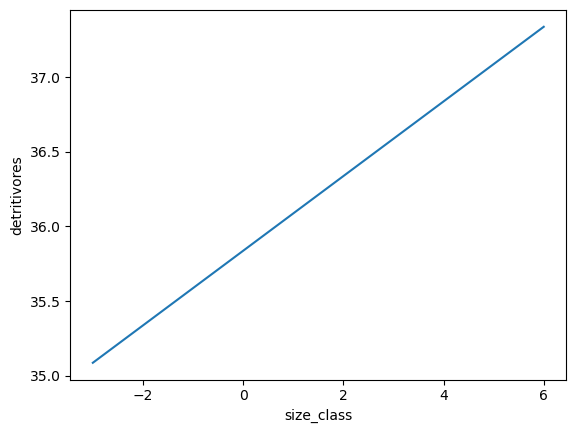

In [58]:
det_summ_all.plot()

Text(0.04, 0.1, 'mean ben.pref: 0.02')

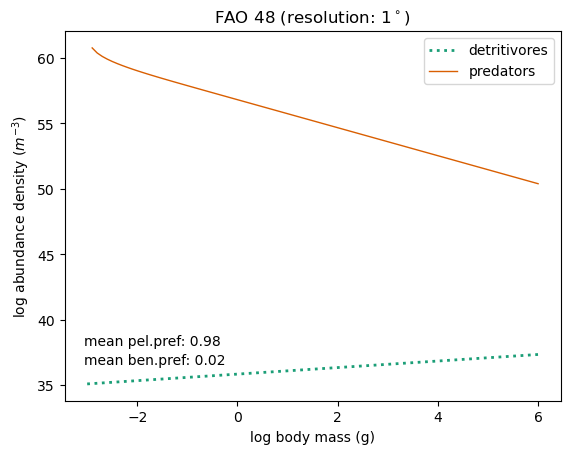

In [60]:
#Initialise figure
fig = plt.figure()
ax = fig.add_subplot()

#Plot detritivore and predator biomass
det_summ_all.plot(ax = ax, color = '#1b9e77', ls = 'dotted', lw = 2, 
              label = 'detritivores')
pred_summ_all.plot(ax = ax, color = '#d95f02', lw = 1, label = 'predators')

#Changing axes labels
ax.set_xlabel('log body mass (g)')
ax.set_ylabel('log abundance density ($m^{-3}$)')

#Adding legend
ax.legend(loc = 'upper right', frameon = True)

#Adding title
#Reformat region variable to use in title
reg_clean = region.upper().replace('-', ' ')
#Adding resolution to title
if model_res == '025deg':
    ax.set_title(f'{reg_clean} (resolution: 0.25$^\circ$)')
elif model_res == '1deg':
    ax.set_title(f'{reg_clean} (resolution: 1$^\circ$)')

#Setting minimum and maximum values along y axis
max_y = max([det_summ_all.max(), pred_summ_all.max()])
# plt.ylim(-20, np.ceil(max_y.values)+1)

#Adding text
ax.text(0.04, 0.15, f'mean pel.pref: {pel_pref}', transform = ax.transAxes)
ax.text(0.04, 0.1, f'mean ben.pref: {ben_pref}', transform = ax.transAxes)

#Saving plot
# fn = f'size_spectrum_mean_{region}_{model_res}_{s_yr}-{e_yr}.png'
# plt.savefig(os.path.join(plot_folder, fn), dpi = 300, bbox_inches = 'tight', 
#             pad_inches = 0.05)

### Option 3: Size spectrum from mean decadal values

In [95]:
pred_summ['decade'] = (np.floor(pred_summ.time.dt.year/10)*10).astype(int)
pred_summ_dec = np.log10(pred_summ.groupby('decade').mean('time').sum(('lat', 'lon')))
det_summ['decade'] = (np.floor(det_summ.time.dt.year/10)*10).astype(int)
det_summ_dec = np.log10(det_summ.groupby('decade').mean('time').sum(('lat', 'lon')))

### Saving results 

In [96]:
size_spectra_dec = xr.Dataset(data_vars = {'predators': pred_summ_dec,
                                           'detritivores': det_summ_dec})
#Getting last year from data
s_dec = pred_summ.decade.min().values.tolist()
e_dec = pred_summ.decade.max().values.tolist()

#Saving plot
fn = f'size_spectrum_mean_decade_{region}_{model_res}_{s_dec}-{e_dec}.nc'
size_spectra_dec.to_netcdf(os.path.join(plot_folder, fn))

### Plotting size spectrum 

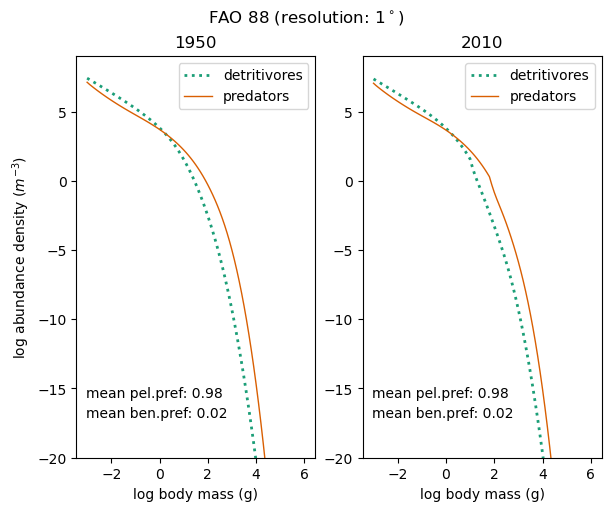

In [97]:
#Initialise figure
fig, ax = plt.subplots(1, 2, figsize = [6, 5], layout = 'constrained')

#Plot detritivore and predator biomass - last decade of spinup
det_summ_dec.sel(decade = 1950).plot(ax = ax[0], color = '#1b9e77', ls = 'dotted', lw = 2, 
              label = 'detritivores')
pred_summ_dec.sel(decade = 1950).plot(ax = ax[0], color = '#d95f02', lw = 1, label = 'predators')
#Add title
ax[0].set_title('1950')

#Plot detritivore and predator biomass - last decade of modelled period
det_summ_dec.sel(decade = 2010).plot(ax = ax[1], color = '#1b9e77', ls = 'dotted', lw = 2, 
              label = 'detritivores')
pred_summ_dec.sel(decade = 2010).plot(ax = ax[1], color = '#d95f02', lw = 1, label = 'predators')
#Add title
ax[1].set_title('2010')

#Finding range for y axis
max_y = max([det_summ_dec.max(), pred_summ_dec.max()])
for a in ax:
    #Changing axes labels
    a.set_xlabel('log body mass (g)')
    #Setting minimum and maximum values along y axis
    a.set_ylim(-20, np.ceil(max_y.values)+1)
    #Adding legend
    a.legend(loc = 'upper right', frameon = True)
    #Adding mean preferences
    a.text(0.04, 0.15, f'mean pel.pref: {pel_pref}', transform = a.transAxes)
    a.text(0.04, 0.1, f'mean ben.pref: {ben_pref}', transform = a.transAxes)

ax[0].set_ylabel('log abundance density ($m^{-3}$)')
ax[1].set_ylabel('')

#Adding title
#Reformat region variable to use in title
reg_clean = region.upper().replace('-', ' ')
#Adding resolution to title
if model_res == '025deg':
    fig.suptitle(f'{reg_clean} (resolution: 0.25$^\circ$)')
elif model_res == '1deg':
    fig.suptitle(f'{reg_clean} (resolution: 1$^\circ$)')

#Saving plot
fn = f'size_spectrum_mean_decade_{region}_{model_res}_1950-2010.png'
plt.savefig(os.path.join(plot_folder, fn), dpi = 300, bbox_inches = 'tight', 
            pad_inches = 0.05)

## Calculate total biomass for `predators` and `detritivores` 

In [11]:
tot_pred_bio = ((predators.isel(size_class = slice(gridded_params['ind_min_pred_size'], 
                                                  None))*
                gridded_params['log_size_increase']*size_bin_vals).
                sum('size_class')).groupby('time.year').mean('time')

tot_pred_det = (detritivores.isel(size_class = 
                                  slice(gridded_params['ind_min_detritivore_size'], 
                                        None))*gridded_params['log_size_increase']*
                size_bin_vals).sum('size_class').groupby('time.year').mean('time')

Text(0.5, 1.0, 'Total predator biomass 1899')

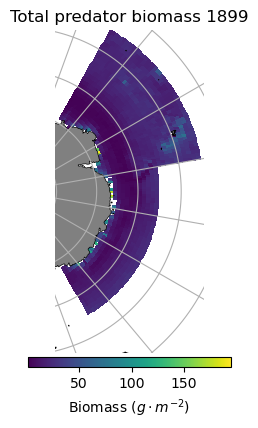

In [12]:
#Initialise figure
fig = plt.figure(figsize = [3.75, 5])
ax = fig.add_subplot(projection = ccrs.SouthPolarStereo())

#Land mask
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', 
                                   facecolor = 'gray', linewidth = 0.5)

#Plot a year
ds = tot_pred_bio.where(tot_pred_bio != 0).isel(year = -1)
p1 = ds.plot(ax = ax, add_colorbar = False, transform = ccrs.PlateCarree())

#Add land
ax.add_feature(land_50m)
#Add gridlines
ax.gridlines()
#Remove rectangular boundaries outside map
[s.set_visible(False) for s in ax.spines.values()]

#Add colorbar below plot
plt.colorbar(p1, ax = ax, orientation = 'horizontal', shrink = 0.7, 
             label = 'Biomass ($g\cdot m^{-2}$)', pad = 0.01)

#Add title
yr = ds.year.values.tolist()
ax.set_title(f'Total predator biomass {yr}')